In [114]:
# Importing all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import datetime, argparse
from mri.operators import Stacked3DNFFT, NonCartesianFFT, WaveletN, WaveletUD2
from mri.operators.utils import normalize_frequency_locations
from mri.reconstructors import SelfCalibrationReconstructor, SingleChannelReconstructor, CalibrationlessReconstructor
from mri.operators.fourier.utils import estimate_density_compensation
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, GroupLASSO
from mri.operators import ORCFFTWrapper
from sparkling.utils.gradient import get_kspace_loc_from_gradfile, get_kspace_points_grads_n_slew
from sparkling.utils.plotting import scatter_shots
from sparkling.utils.shots import convert_NCxNSxD_to_NCNSxD, convert_NCNSxD_to_NCxNSxD
from sparkling.utils.argparse import get_params_n_basename

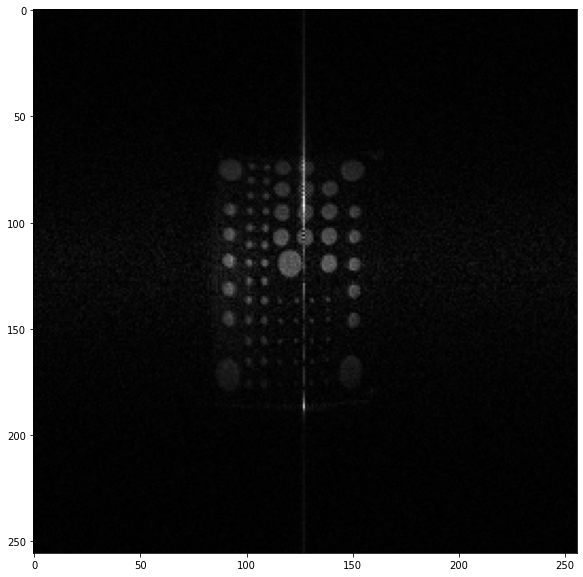

In [115]:
# Loading the data & trajectory
import nibabel as nib

phantom = nib.load('/neurospin/optimed/KPooja/Sparkling/CSMRI_sparkling/tcc256256_vlfmri_phantom.nii').get_fdata()
traj_file = "/neurospin/optimed/KPooja/Sparkling/Output/dim2_i_RadialIO_TRW0.0_N256x256_FOV0.2x0.2_Nc64_Ns720_OSF1_c20.0_d1.1__D15M6Y2023T1443.bin"

phantom = phantom[:,:,0]
# Plotting the 2D volume
plt.figure(figsize=(10,10))
plt.imshow(phantom, cmap='gray')

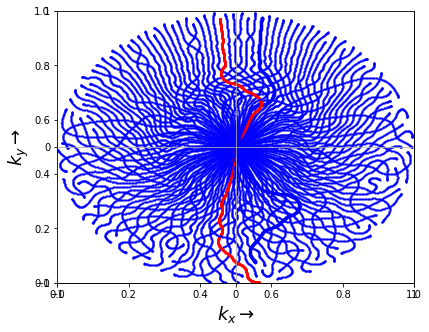

/neurospin/optimed/KPooja/Sparkling/CSMRI_sparkling/sparkling/utils/gradient.py:28: UserWarning: Gradient Maximum Maginitude overflow from Machine capabilities
  warnings.warn("Gradient Maximum Maginitude "
/neurospin/optimed/KPooja/Sparkling/CSMRI_sparkling/sparkling/utils/gradient.py:33: UserWarning: Slew Rate overflow from Machine capabilities!
Occurences per shot : 13.53125
Max Value : 0.00030892735646814354
  warnings.warn("Slew Rate overflow from Machine capabilities!\n"


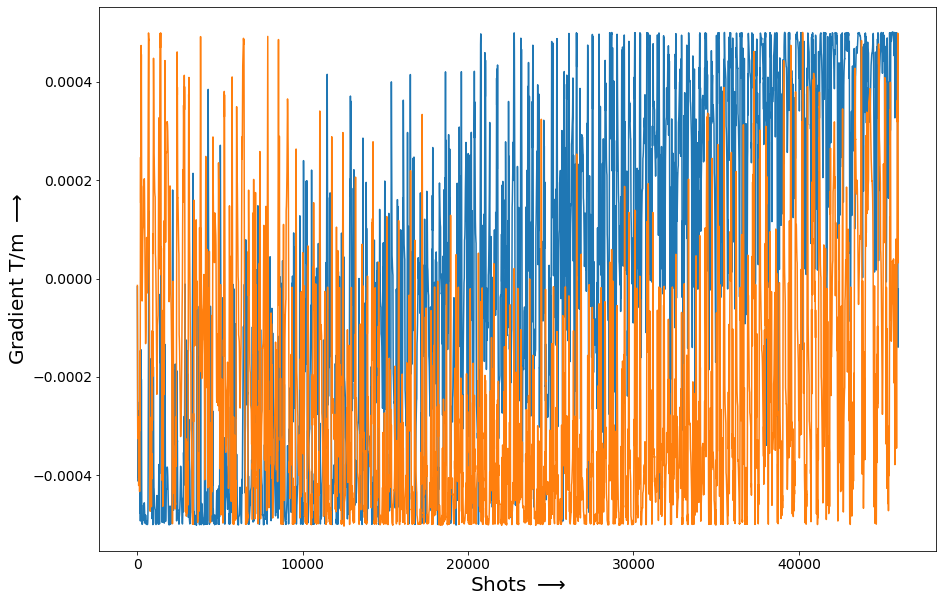

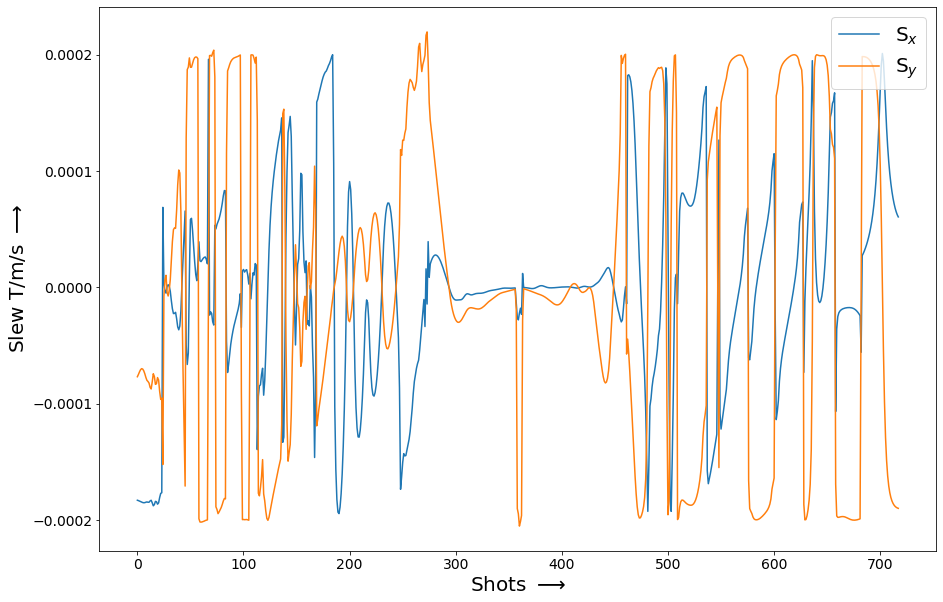

In [116]:
# Plotting SPARKLING Trajectories, its gradient profile and slew rate
shots, params = get_kspace_loc_from_gradfile(traj_file, verbose=1)
INIT, filename = get_params_n_basename(traj_file)
grads, k0, slew = get_kspace_points_grads_n_slew(
    shots,
    INIT,
    check=True,
    normalized=False
)

# k0 is K_start point for gradient preparation of size (Nshots, ndim)

# grad = convert_NCxNSxD_to_NCNSxD(grads)
# grad_l2 = np.sqrt(grad[:,0]*grad[:,0] + grad[:,1]*grad[:,1])

plt.figure(figsize=(15,10))
plt.plot(convert_NCxNSxD_to_NCNSxD(grads))
plt.xlabel('Shots $\longrightarrow$', fontsize = 20)
plt.ylabel('Gradient T/m $\longrightarrow$', fontsize = 20)
plt.tick_params(labelsize=14)

plt.figure(figsize=(15,10))
plt.plot(slew[25,:,1], label="S$_x$")
plt.plot(slew[25,:,0], label="S$_y$")
plt.xlabel('Shots $\longrightarrow$', fontsize = 20)
plt.ylabel('Slew T/m/s $\longrightarrow$', fontsize = 20)
plt.tick_params(labelsize=14)
plt.legend(loc="upper right", prop={'size': 16})
plt.legend(loc="upper right", fontsize = 20)


In [117]:
# np.save('vlfmri_sparkling_0.5mT_mGmax_28Apr2023_64shots.npy', grads)
# np.savetxt('vlfmri_sparkling_0.5mT_mGmax_28Apr2023_64shots_KStart.txt', k0)

In [119]:
# Defining fuctions to get trajectory parameters and sample location
def get_traj_params(traj_file):
    dico_params = get_kspace_loc_from_gradfile(traj_file)[1]
    FOV = dico_params['FOV']
    M = dico_params['img_size']
    Ns = dico_params['num_samples_per_shot']
    OS = dico_params['min_osf']
    return(FOV, M, Ns, OS)

def get_norm_samples(filename, dwell_t, num_adc_samples, kmax):
    sample_locations = convert_NCxNSxD_to_NCNSxD(get_kspace_loc_from_gradfile(filename, dwell_t, num_adc_samples)[0])
    sample_locations = normalize_frequency_locations(sample_locations, Kmax= kmax)
    return sample_locations

def single_coil_recon(mu, dens_compense, kspace_data, kspace_loc, M, iter):
    if dens_compense == True:
        density_comp = estimate_density_compensation(kspace_loc, M)                              
        fourier_op = NonCartesianFFT(samples=kspace_loc,
                              shape= M,
                              implementation='gpuNUFFT',
                              density_comp = density_comp,
                              n_coils=1,)
    else:
        fourier_op = NonCartesianFFT(samples=kspace_loc,
                              shape= M,
                              implementation='gpuNUFFT',
                              n_coils=1,)
    
    regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")
    
    linear_op = WaveletN(wavelet_name='sym8',
                         nb_scale=3,
                         dim=2,
                         padding='periodization')
        
    reconstructor = SingleChannelReconstructor(
                        fourier_op=fourier_op,
                        linear_op=linear_op,
                        regularizer_op=regularizer_op,
                        gradient_formulation='synthesis'
                        )

    reconst_data, costs, metrics = reconstructor.reconstruct(kspace_data= kspace_data, optimization_alg = 'pogm', num_iterations = iter,)

    return(reconst_data, costs, metrics)

In [120]:
FOV, M, Ns, OS = get_traj_params(traj_file)
dwell_time = 0.1e-3 / OS
nb_adc_samples = Ns*OS
Te = 31e-3
time_vec = dwell_time * np.arange(nb_adc_samples)
echo_time = Te - dwell_time * nb_adc_samples / 2
time_vec = (time_vec + echo_time)

In [121]:
FOV, M, Ns, OS = get_traj_params(traj_file)
kspace_loc = get_norm_samples(traj_file, dwell_t = dwell_time*1e3, num_adc_samples = Ns*OS, kmax=(M[0]/(FOV[0]), M[1]/FOV[1]))

density_comp = estimate_density_compensation(kspace_loc, phantom.shape)
fourier_op = NonCartesianFFT(
        samples=kspace_loc,
        shape=phantom.shape,
        implementation='gpuNUFFT',
        density_comp = density_comp,
        n_coils= 1)

new_kspace = np.ascontiguousarray(fourier_op.op(np.ascontiguousarray(phantom)))       

print(kspace_loc.shape)
kspace_locations = kspace_loc.reshape((-1, 2)).astype(np.float32)
print(kspace_locations.shape)

(46080, 2)
(46080, 2)


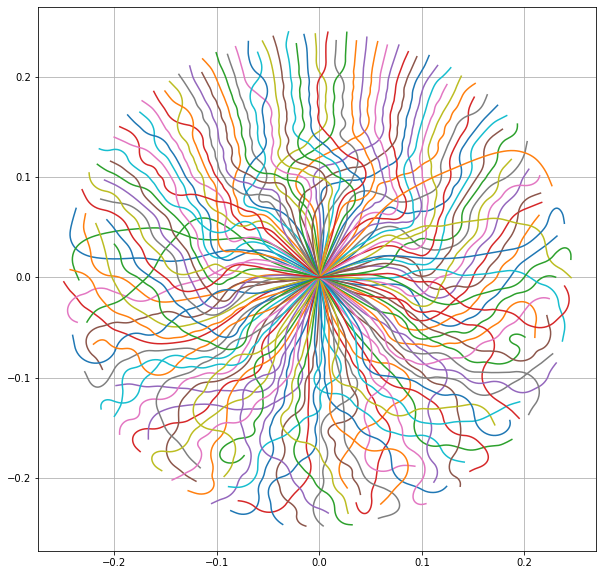

In [123]:
nb_shots = 64
plt.figure(num=3, figsize = (10,10))
for i in range(nb_shots):
    plt.plot(kspace_locations.reshape((-1, Ns*OS, 2))[i, :, 0],
             kspace_locations.reshape((-1, Ns*OS, 2))[i, :, 1])

plt.grid()
plt.show()


In [124]:
recont_data, costs, metric= single_coil_recon(1e-3, True, new_kspace, kspace_loc, phantom.shape, 500)

N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30
  0% (4 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29
  1% (6 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28
  1% (7 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28
  1% (9 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27
  2% (11 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:27
  2% (13 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:27
  3% (15 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:27
  3% (17 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:26
  3% (19 of 500) |                       | Elapsed Time: 0:00:01 ETA:   0:00:26
  4% (21 of 500) |                       | Elapsed Time: 0:00:01 ETA:   0:00:26
  4% (23 of 500) |#                     

(256, 256)


Text(0.5, 1.0, '2D VLFMRI Sparkling : SSIM = 0.8601, PSNR = 28.0864')

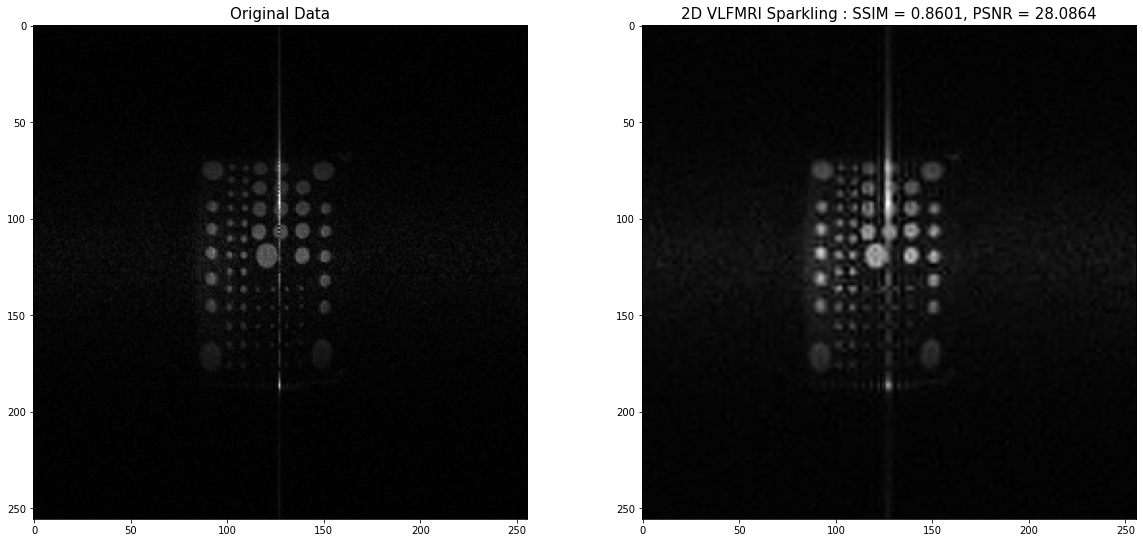

In [125]:
import matplotlib.pyplot as plt
from modopt.math.metrics import ssim, psnr
plt.figure(num=2, figsize = (20,20))
plt.subplot(2,2,1)
plt.imshow(abs(phantom), cmap='gray')
plt.title("Original Data", fontsize=15)
plt.subplot(2,2,2)
vol = recont_data
print(vol.shape)
my_ssim = ssim(vol, phantom)
plt.imshow(abs(vol), cmap='gray')
plt.title("2D VLFMRI Sparkling : SSIM = {:.4f}, PSNR = {:.4f}".format(my_ssim, psnr(vol, phantom)), fontsize = 15)
